# Predict Which Clients will Cancel Subscription to help Account Managers Reduce Churn using KNN

Our subcription based pricing model means we are exposed to clients cancelling their payments. Therefore, we 
want to be able to predict which clients will cancel their subscription to help Account Managers drive engagement and reduce cancellations. 

Please note that the data has been anonymised.

# 1. Import Libaries

Below we are importing all the Python libraries we will need for this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.gridspec import GridSpec

plt.style.use('fivethirtyeight')
%matplotlib inline
palette = itertools.cycle(sns.color_palette())

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# 2. Import Data

In [2]:
columns = ['customerid','client_status','account_status','customer_name','customer_type','value','year_of_current_deal','cancellation_timing','sector','cancellation_reason']
renewals = pd.read_csv('~/Documents/portfolio/datasets/Renewal-Cancelation Book Anonymised3.csv', names=columns, header=0)
renewals.sample(5)

,customerid,client_status,account_status,customer_name,customer_type,value,year_of_current_deal,cancellation_timing,sector,cancellation_reason
442,792,High,Active,410,Three,4120,2,NaN,Support Services,NaN
553,2535,High,Active,919,Three,5000,1,NaN,Travel & Leisure,NaN
95,663,high,Inactive,184,Two,4000,1,Yes,Financials,Switched to competitor
1073,2155,High,Active,364,Three,5500,1,NaN,Financials,NaN
924,352,Mid,Inactive,311,Two,4500,1,NaN,General,We terminated contract


Importing the renewal data we have the following variables:

In [3]:
renewals.dtypes

customerid               int64
client_status           object
account_status          object
customer_name            int64
customer_type           object
value                    int64
year_of_current_deal     int64
cancellation_timing     object
sector                  object
cancellation_reason     object
dtype: object

To give a description of each variable:

<br>

<b>customerid</b> : 
a unique identifier for each account that will be used to join additional datasets later on 

<b>client_status</b> : 
a grading system of the account given by the account manager that denotes the level of usage and engagement, high means no cause for concern as high engagement and usage and low means little/no usage and engagement, high risk of cancellation.

<b>account_status</b> : 
denotes whether the client is active (paying customer) or inactive (cancelled)

<b>customer_name</b> : 
customer number     

<b>customer_type</b> : 
we categorise into three pots of client according to size in revenue; one being the smallest, and three being the largest.

<b>value</b> : 
the current price of subscription, there are three types of subcription for which the prices differ and this is dependent on the customer type.

<b>year_of_current_deal</b> : 
the year of maturity of the account

<b>cancellation_timing</b> : 
shows if the cancellation was at the start of a period or mid way through

<b>sector</b>: 
the industry that the customer operates in 

<b>cancellation_reason</b> : 
a reason for cancellation picked from a preset list of reasons

# 3. Exploratory Data Analysis (EDA) - For Data Cleaning

In this section we will clean the initial dataset. To give us an idea of the size of the initial data we are working with, it has 1,152 rows and 10 columns. 

In [4]:
renewals.shape

(1152, 10)

In [5]:
# Identifing null values

renewals.isnull().sum()

customerid                 0
client_status             18
account_status             0
customer_name              0
customer_type              0
value                      0
year_of_current_deal       0
cancellation_timing     1097
sector                     0
cancellation_reason      899
dtype: int64

In [6]:
# Dropping any unwanted columns. 

renewals.drop(columns=['cancellation_timing'],
              inplace=True)

In [7]:
# Indentifying the rows of the null values - they are newly won clients waiting for an engagement rating from Account Managers

renewals[renewals['client_status'].isnull()].any(axis=1)

44      True
47      True
329     True
330     True
334     True
336     True
464     True
603     True
613     True
883     True
912     True
920     True
935     True
967     True
997     True
1037    True
1060    True
1097    True
dtype: bool

In [8]:
# We can fill these 18 account status' in with 'Unknown'

renewals['client_status'].fillna('Unknown', inplace = True)

In [9]:
# Checking that the previous null values are filled as expected

renewals.loc[44]

customerid                             228
client_status                      Unknown
account_status                    Inactive
customer_name                           91
customer_type                        Three
value                                 4000
year_of_current_deal                     2
sector                          Financials
cancellation_reason     No longer required
Name: 44, dtype: object

In [10]:
# Exploring the client status shows us that we should merge the two high categories.

renewals['client_status'].value_counts()

Mid        527
High       482
Low         75
high        50
Unknown     18
Name: client_status, dtype: int64

In [11]:
# Cleaning the two high categories

renewals['client_status'] = renewals['client_status'].replace({'high': 'High'})
renewals['client_status'].value_counts()

High       532
Mid        527
Low         75
Unknown     18
Name: client_status, dtype: int64

In [12]:
# Checking how many inactive customers have a missing value in cancellation reason

cancelled = renewals[renewals['account_status'] == 'Inactive']
cancelled[cancelled['cancellation_reason'].isnull()].any(axis=1)

163    True
263    True
737    True
870    True
dtype: bool

In [13]:
# filling in the cancellation reason of the inactive accounts with 'Reason Unknown'.

renewals.loc[((renewals.account_status == 'Inactive') & (renewals.cancellation_reason.isnull())), 
             'cancellation_reason'] ='Reason Unknown'

In [14]:
# checking that the 32 cancelled account's cancellation reasons have been filled in

renewals.isnull().sum()

customerid                0
client_status             0
account_status            0
customer_name             0
customer_type             0
value                     0
year_of_current_deal      0
sector                    0
cancellation_reason     895
dtype: int64

In [15]:
# Checking cancellation reason to see what the options are and if it needs cleaning

renewals['cancellation_reason'].value_counts()

No longer required              132
Switched to competitor           62
Insufficient Funds               34
Data Quality                     12
Low engagement                    5
Merged with exsisting client      4
Reason Unknown                    4
We terminated contract            2
Data quality                      2
Name: cancellation_reason, dtype: int64

In [16]:
# Combining the two data quality buckets 

renewals['cancellation_reason'] = renewals['cancellation_reason'].replace({'Data Quality': 'Data quality'})
renewals['cancellation_reason'].value_counts()

No longer required              132
Switched to competitor           62
Insufficient Funds               34
Data quality                     14
Low engagement                    5
Merged with exsisting client      4
Reason Unknown                    4
We terminated contract            2
Name: cancellation_reason, dtype: int64

In [16]:
# Checking for duplicate entries for clients

renewals.customer_name.value_counts()

569     2
1151    1
386     1
380     1
381     1
       ..
768     1
769     1
770     1
771     1
1       1
Name: customer_name, Length: 1151, dtype: int64

In [17]:
# locating the rows of the duplicate accounts and checking both rows have the same information before deleting one

duplicate_name = renewals.customer_name == 569
renewals[duplicate_name]

,customerid,client_status,account_status,customer_name,customer_type,value,year_of_current_deal,sector,cancellation_reason
173,1490,Mid,Inactive,569,Two,10500,1,General,Switched to competitor
174,1490,Mid,Inactive,569,Two,10500,1,General,Switched to competitor


In [18]:
# Deleting the one duplicate row where the cancellation reason is unknown

renewals.drop(renewals.index[173], inplace = True)

In [19]:
# Checking there are no more duplications

renewals.customer_name.value_counts()

1151    1
386     1
380     1
381     1
382     1
       ..
768     1
769     1
770     1
771     1
1       1
Name: customer_name, Length: 1151, dtype: int64

In [20]:
# Another check that a row was permanently deleted from dataset

renewals.shape

(1151, 9)

In [21]:
# Inspecting the account status

renewals['account_status'].value_counts()

Active      895
Inactive    256
Name: account_status, dtype: int64

Please refer to the project in a separate Jupyter Notebook called 'Data Cleaning and Visualisation to Give Insights Into Cancelling Clients' for visualisations that explore the variables in this dataset. 

# 5. K-Nearest Neighbours (KNN) Classification

In this section we will use KNN Classification to predict the account status of a client either 'active' or 'inactive' using information we would only know on day 1 of their subscription.

The model will search for a number of customers in the data that are 'nearest' in measurement to the account with unknown account status, it will then predict a value for account status (active or inactive) from the most frequently observed value from the 'nearest' customers in the data. The number of close proximity customers the model considers before making a prediction is up to us and denoted by k.

First we will define the target, which is the account status and then we will define the predictors, which are customer type, sector and value.

In [22]:
# Setting up the features

cat_cols = ['customer_type','sector']
cont_cols = ['value']
X = pd.concat([
    renewals[cont_cols], 
    pd.get_dummies(renewals[cat_cols], drop_first=True) # turning the predictor categoric variables into dummy 
    # variables for learning purposes and dropping one
], axis = 1)

# Setting up the target

renewals['account_status_map'] = renewals.account_status.map({'Inactive':0, 'Active':1})

y = renewals.account_status_map

In [23]:
# Checking types are as expected and that a dummy variable has been dropped from each predictor

X.dtypes

value                       int64
customer_type_Three         uint8
customer_type_Two           uint8
sector_Consumer Finance     uint8
sector_Consumer Products    uint8
sector_Education            uint8
sector_Energy               uint8
sector_Financials           uint8
sector_Freelancer           uint8
sector_General              uint8
sector_Government Bodies    uint8
sector_Healthcare           uint8
sector_Industry             uint8
sector_Insurance            uint8
sector_Media                uint8
sector_Mining               uint8
sector_Property             uint8
sector_Retailers            uint8
sector_Support Services     uint8
sector_Technology           uint8
sector_Telecoms             uint8
sector_Transport            uint8
sector_Travel & Leisure     uint8
sector_Utilities            uint8
dtype: object

In [24]:
X

,value,customer_type_Three,customer_type_Two,sector_Consumer Finance,sector_Consumer Products,sector_Education,sector_Energy,sector_Financials,sector_Freelancer,sector_General,...,sector_Media,sector_Mining,sector_Property,sector_Retailers,sector_Support Services,sector_Technology,sector_Telecoms,sector_Transport,sector_Travel & Leisure,sector_Utilities
0,4950,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5030,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5500,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4950,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6050,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,4750,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1148,5100,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1149,4500,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1150,5100,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


The next steps split our data into 2 parts, the first is 863 rows, which we will feed into our model first for it to learn the relationships between the account status and the customer type, value and sector. We will then optimise the model's ability to predict the account status by tuning the parameters. Following that we will use the second batch of data of 288 rows to test the model's accuracy of predicting the account status of customers whose information it has not seen before using what it has learnt about the relationships of the variables from training. 

In [25]:
# Spliting the dataset into train and test by 75%/25%. Using the random state means the split will happen by the 
# same random everytime, meaning if someone else were to test the model they could use the same random state number and 
# get the same split.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60)

In [26]:
# Dataset before splitting

print(X.shape)

# After splitting

print(X_train.shape)
print(X_test.shape)

(1151, 24)
(863, 24)
(288, 24)


In [27]:
# Dataset before splitting

print(y.shape)

# After splitting

print(y_train.shape)
print(y_test.shape)

(1151,)
(863,)
(288,)


Next, we standardise the data after splitting it, this is so that the model doesn't get any information about the test subset of data through the mean in the calculation. We want the test data to be completely new to the model when we introduce it so that we can judge it's true accuracy in predicting account status of unseen data.

In [28]:
# Standardise the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
X_train

array([[-1.63274077, -1.13807415, -0.67113349, ..., -0.08367298,
        -0.23454685, -0.06823912],
       [ 0.05242807, -1.13807415,  1.49001653, ..., -0.08367298,
        -0.23454685, -0.06823912],
       [ 0.37179475, -1.13807415,  1.49001653, ..., -0.08367298,
        -0.23454685, -0.06823912],
       ...,
       [ 0.23589403, -1.13807415,  1.49001653, ..., -0.08367298,
        -0.23454685, -0.06823912],
       [ 0.06601814, -1.13807415, -0.67113349, ..., -0.08367298,
        -0.23454685, -0.06823912],
       [ 0.40576992,  0.87867737, -0.67113349, ..., -0.08367298,
        -0.23454685, -0.06823912]])

In [30]:
# Training the model with the train set of data where k=1

knn = KNeighborsClassifier(n_neighbors=1)

# Fitting the model

knn.fit(X_train, y_train.astype(int))


KNeighborsClassifier(n_neighbors=1)

In [31]:
# Store the predicted response values of y_test

y_pred_class = knn.predict(X_test)

# Accuracy of model 

print((metrics.accuracy_score(y_test, y_pred_class)))

0.6805555555555556


Our model predicts with 68% accuracy the correct account status when considering the 1 closest customer in the dataset. However, this isn't hard given we have an imbalance in account status', with the majority (74%) of the customers live.

By calculating the baseline accuracy we can find the minimum accuracy that is achieved by always predicting the most frequent account status.

In [32]:
# Confirming the most frequent class is 1 to find a baseline accuracy. 

most_freq_class = y_train.value_counts().index[0]

print(y_train.value_counts())
most_freq_class

1    668
0    195
Name: account_status_map, dtype: int64


1

In [33]:
# calculating different baseline accuracies

baseline_accuracyone = y_test.value_counts()[most_freq_class] / len(y_test)
baseline_accuracytwo = metrics.accuracy_score(y_test, np.zeros(len(y_test)))
baseline_accuracythree = metrics.accuracy_score(y_test, np.random.randint(2, size=(len(y_test))))

print(baseline_accuracyone)
print(baseline_accuracytwo)
print(baseline_accuracythree)

0.7881944444444444
0.21180555555555555
0.5208333333333334


Comparing different baseline accuracy measures shows varying results. The highest accuracy showing that if we were to predict each unknown account status as live we would have predicted 78.8% of the whole dataset correctly. Therefore, if our KNN model cannot improve on this level of accuracy it won't be a useful model.

Therefore, let's find the optimal value for k to see if we can improve our model.

In [34]:
# Running a KNN model for k=1 to 99 and making a list of scores to plot to find the optimal value for k. 

scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])

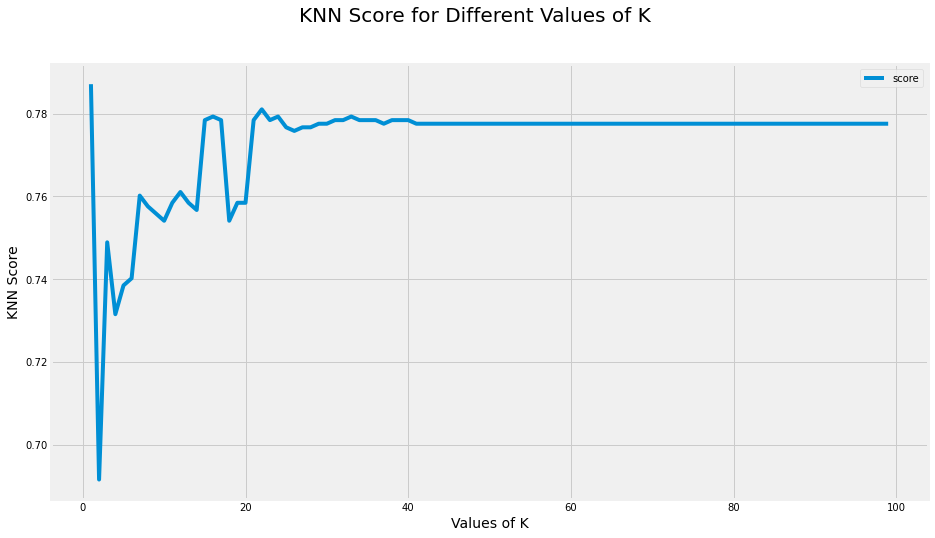

In [35]:
# Shows the variation of accuracy when the size of k increases

data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score', figsize = (14,8));

plt.xlabel('Values of K', fontsize = 14);
plt.ylabel('KNN Score', fontsize = 14);
plt.suptitle('KNN Score for Different Values of K', fontsize=20);

In [36]:
# Calculating the training and testing error for K=1 through 100 so that we can use a value for K that has both 
# the greatest score and also the least errors.

k_range = list(range(1, 101))
training_error = []
testing_error = []


for k in k_range:

    # Instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy)
    y_pred_class = knn.predict(X_train)
    training_accuracy = metrics.accuracy_score(y_train, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [37]:
# Creating a DataFrame of K, training error, and testing error

column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
100,0.225956,0.211806
99,0.225956,0.211806
98,0.225956,0.211806
97,0.225956,0.211806
96,0.225956,0.211806


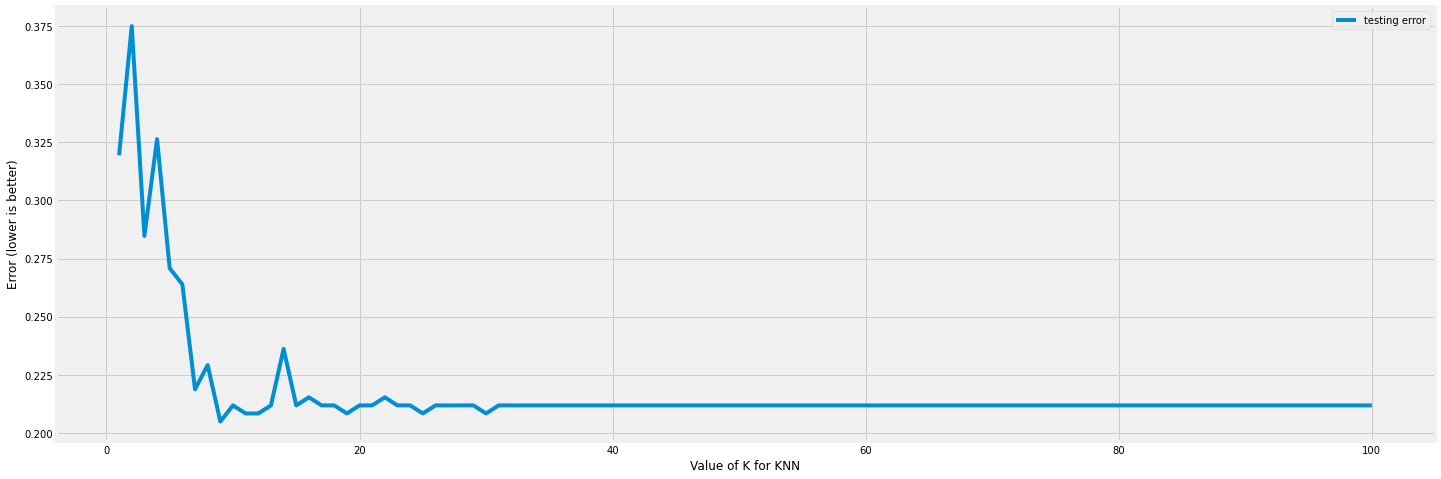

In [38]:
# Plotting the relationship between K and testing error. 

df.plot(y='testing error', figsize =(22,8));
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

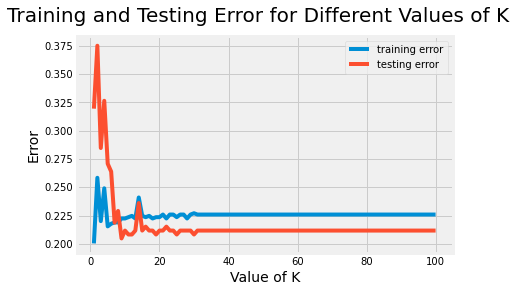

In [39]:
# Plot the relationship between K and both the training error and testing error.

df.plot();
plt.xlabel('Value of K', fontsize = 14);
plt.ylabel('Error', fontsize = 14);
plt.suptitle('Training and Testing Error for Different Values of K', fontsize=20);

We want to select the value of k when the testing error is the lowest. In the graph above, the errors plateaus, therefore the model is likely underfitting. This is because the model is unable to capture the relationship between  the account status and the predictor variables. This could be because the model is too simple, the input features are not expressive enough to describe the target well. 

In [40]:
# Finding the optimal k value with the lowest testing error.

min(list(zip(testing_error, k_range)))

(0.20486111111111116, 9)

In [41]:
# Running the KNN model again using the optimal value of K, 9. 

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
knn_score = metrics.accuracy_score(y_test, y_pred_class)
knn_score

0.7951388888888888

In [42]:
# Computing the validation score 100 consecutive times (with different splits each time).
# The results show scores within the range 62.5% - 88.8%.

cross_val_score(knn, X_train, y_train, cv=100, scoring='accuracy')

array([0.77777778, 0.66666667, 0.77777778, 0.66666667, 0.77777778,
       0.66666667, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.66666667, 0.77777778, 0.66666667, 0.77777778,
       0.77777778, 0.88888889, 0.77777778, 0.77777778, 0.88888889,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.66666667,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.88888889, 0.77777778, 0.77777778, 0.77777778, 0.77777778,
       0.77777778, 0.77777778, 0.77777778, 0.77777778, 0.66666667,
       0.88888889, 0.77777778, 0.77777778, 0.875     , 0.75      ,
       0.875     , 0.875     , 0.875     , 0.75      , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.875     , 0.75   

In [43]:
print("Highest baseline accuracy: " + str(baseline_accuracyone))
print("KNN accuracy score: " + str(knn_score))
print("Difference in accuracy score between baseline accuracy and our model: " + str(knn_score - 
                                                                                     baseline_accuracyone))

Highest baseline accuracy: 0.7881944444444444
KNN accuracy score: 0.7951388888888888
Difference in accuracy score between baseline accuracy and our model: 0.00694444444444442


From finding the optimal k of 9 we can add 0.0069% accuracy to predictions with our model. More specifically this means that given new data our model will look to the closest 9 customers to each new customer and predict a value for account status (active or inactive) from the most frequently observed value from those 9 with 79.5% accuracy each time.